In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512 
tau_sim = 1.0        
DTS = 8     

# Glasma
su_group = 'su3'
Qs = 2.0     
ns = 50      
factor = 0.8        
uv = 10.0 

# Wong
quark = 'charm'    
mass = 1.275   
tau_form = 1/(2*mass)*hbarc    

# tau_sim += tau_form

initialization = 'pT'         
ntp = 10**5 

nevents = 5

representation = 'quantum fundamental'     
# representation = 'test'     
# representation = 'fundamental' 
# representation = 'adjoint' 
boundary = 'periodic'  
form_time = 'm'

# pTs = [0, 0.5, 1, 5]
# binning = 'pT2'
binning = 'pT'
npTbins = 2 
pTmax = 1
if binning=='pT':
    pTbins = np.linspace(0, pTmax, npTbins)
elif binning=='pT2':
    pTbins = np.linspace(0, pTmax**2, npTbins)
deltapTbin = pTbins[1] - pTbins[0]

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,   
    'TFORM': tau_form,
    'TSIM': tau_sim,
    'QS': Qs,            
    'NEVENTS': nevents,
    'NTP': ntp,   
    'PTS': pTbins,
    'NPTBINS': npTbins,
    'PTMAX': pTmax,
    'REPR': representation,
    'SUGROUP': su_group,
    'FORMTIME': form_time,
    'BINNING': binning,
    }

In [2]:
# rest of parameters  
g2mu = p["QS"] / factor     
g = np.pi * np.sqrt(1 / np.log(p["QS"] / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g2mu     

tau_form = 1/(2*p["MASS"])*hbarc
tau_sim += tau_form

if representation == 'quantum fundamental':
    repr_name = 'qfund'
elif representation == 'fundamental':
    repr_name = 'fund'
elif representation == 'adjoint':
    repr_name = 'adj'
elif representation == 'test':
    repr_name = 'test'

# Results folder
folder = 'gaussian_broadening_' + p["QUARK"] + '_Qs_' + str(p["QS"]) + '_' + repr_name + '_' + p["SUGROUP"] + '_formt_' + p["FORMTIME"]

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = p["SUGROUP"]

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.WONG_TO_HOST = True
from curraun.wong import init_pos, init_charge, init_mom_toy
from curraun.particles_correlators import TransMom

Using CUDA
Using SU(3)
Using double precision
Using double precision


In [4]:
import pickle
from tqdm import tqdm

current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'

In [5]:
def simulate(p, ev): 
    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS

    pT = p["PT"]

    if p["FORMTIME"]=='m':
        tau_form = 1/(2*p["MASS"])*hbarc
    elif p["FORMTIME"]=='mT':
        # transverse mass
        mT = np.sqrt(p["MASS"]**2+pT**2)   
        # formation time given by inverse of transverse mass
        tau_form = 1/(2*mT)*hbarc

    p["TFORM"] = tau_form

    tau_sim = p["TSIM"] + tau_form 

    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

   
    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = p["MASS"] / E0 * np.ones(ntp)


    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(representation)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0
    
    wong_solver.initialize(x0s, p0s, q0s, masses)

    # px = np.zeros((maxt-formt, ntp))
    # py = np.zeros((maxt-formt, ntp))

    compute_pT = TransMom(wong_solver, ntp)
    # p2s = np.zeros((maxt-formt, ntp, 3))
    sigmapTs = np.zeros(maxt-formt)

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                # pmu = wong_solver.p.copy() 
                
                # px[t-formt] = pmu[:, 1] * E0
                # py[t-formt] = pmu[:, 2] * E0

                # wong_solver.compute_mom_broad()
                
                wong_solver.evolve()

                compute_pT.compute()
                p2s_sim = compute_pT.p2.copy() * E0**2
                # p2s[t-formt] = p2s_sim
                sigmapTs[t-formt] = np.sqrt(np.std(p2s_sim))


            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    # output[str(pT)]['pTs_event_'+ str(ev+1)] = pTs
    # output[str(pT)]['initial_pTs_event_'+ str(ev+1)] = initial_pTs

    tau = np.linspace(0, tau_sim-tau_form, maxt-formt)
    # output['tau'] = tau

    # return tau, px, py
    # return tau, p2s
    return tau, sigmapTs

In [6]:
print(p['QUARK'].capitalize() + " quark")
os.chdir(results_path)

# output = {}
# output['parameters'] = p.copy()
# output['pTs'] = p['PTS']
# output['nevents'] = p["NEVENTS"]

# wong_folder = folder
# if not os.path.isdir(wong_folder):
#     os.makedirs(wong_folder)
# wong_path = results_path + '/' + wong_folder + '/'
# os.chdir(wong_path)

# px_tau, py_tau = {}, {}
# p2s_tau = {}
sigmapTs = {}

#TODO: Remove this after testing
p['PTS'] = [0, 1]

for ipT, pT in enumerate(p['PTS']):
    print("pT = " + str(pT) + " GeV")
    p["PT"] =  pT

    # px_tau[str(pT)], py_tau[str(pT)] = {}, {}
    collect_sigmapTs = []

    # output[str(pT)] = {}
    for iev, ev in enumerate(range(0, p["NEVENTS"])):
        # print("event " + str(iev+1))
        # tau, px, py = simulate(p, ev)
        # px_tau[str(pT)], py_tau[str(pT)] = px, py

        tau, sigmapT_ev = simulate(p, ev)

        # filename_pT_ev = 'pT_' + str(pT) + '_ev_' + str(iev+1)
        # np.savez_compressed(filename_pT_ev, px=px, py=py)
        # np.savez_compressed(filename_pT_ev, p2s=p2s_tau[str(pT)], tau=tau)

        collect_sigmapTs.append(sigmapT_ev)

    sigmapTs[str(pT)] = np.mean(collect_sigmapTs, axis=0)


p["TAU"] = tau

# with open('parameters.pickle', 'wb') as handle:
#     pickle.dump(p, handle)

Charm quark
pT = 0 GeV


Event 5: 100%|██████████| 441/441 [01:55<00:00,  3.82it/s]


pT = 1 GeV


Event 5: 100%|██████████| 441/441 [01:55<00:00,  3.81it/s]


In [8]:
output = {}

output['parameters'] = p.copy()
output['sigmapT'] = sigmapTs
output['tau'] = tau
output['pTs'] = p['PTS']

with open(current_path + '/notebooks/gaussian_broadening_' + p["QUARK"] + '_Qs_' + str(p["QS"]) + '.pickle', 'wb') as handle:
    pickle.dump(output, handle)

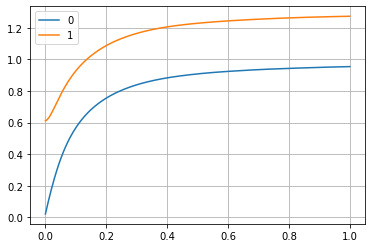

In [7]:
import numpy as np
import matplotlib.pyplot as plt

for pT in p['PTS']:
    plt.plot(tau, sigmapTs[str(pT)], label=str(pT))

plt.legend()
plt.grid(True)
plt.show()

---
Trials

In [19]:
# Fix initial pT and tau
ipT = p['PTS'][1]
itau = 10

ipx2, ipy2 = p2s_tau[str(ipT)][itau, :, 0], p2s_tau[str(ipT)][itau, :, 1]
ipT2 = p2s_tau[str(ipT)][itau, :, 2]

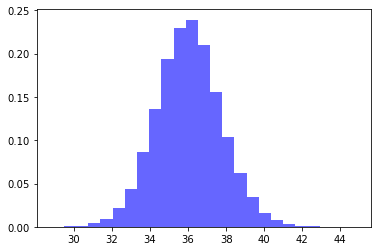

In [20]:
import numpy as np
import matplotlib.pyplot as plt
 
plt.hist(ipT2, bins=25, density=True, alpha=0.6, color='b')
 
plt.show()

In [21]:
np.sqrt(np.std(ipT2))

1.3104388881075033

---
Old trials

In [ ]:
def Gaussian_2d(xy, A,mu_x,mu_y,sigma_x,sigma_y):
    x, y = xy
    G= A*np.exp(-(x-mu_x)**2/(2*sigma_x**2) - (y-mu_y)**2/(2*sigma_y**2) )
    return np.ravel(G)

In [ ]:
ipxpy = np.meshgrid(ipx, ipy)

In [ ]:
from scipy.optimize import curve_fit

p0 = np.array([0.05, 99,99,47,47])

x = np.linspace(-10, 10, 101)
y = np.linspace(-10, 10, 101)

popt, pcov = curve_fit(Gaussian_2d, (x,y), ipxpy, p0)